
# ROOM OCCUPANCY PROJECT

This is a simple project aiming at estimating the occupancy (count) of a room using data recorded by different sensors (temperature, CO2, sound, light and motion) as a function of time.  
Data are based on a [paper published in IEEE](https://ieeexplore.ieee.org/document/8644432) and can be found on [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation).

Best results are 0.984 accuracy and 0.953 macro F1-score when using 10-fold cross validation on the whole dataset using SVM (RBF).

## DATA COLLECTION

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from main import read_file_df,plot_columns_time_occupancy_2017,print_metrics
from main import plot_columns_time_occupancy_2017

Save data to daframe.

In [2]:
file_path = 'https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip'
df = read_file_df(file_path)

In [3]:
df.head(5)

,date,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017-12-22 10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017-12-22 10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017-12-22 10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017-12-22 10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  10129 non-null  datetime64[ns]
 1   S1_Temp               10129 non-null  float64       
 2   S2_Temp               10129 non-null  float64       
 3   S3_Temp               10129 non-null  float64       
 4   S4_Temp               10129 non-null  float64       
 5   S1_Light              10129 non-null  int64         
 6   S2_Light              10129 non-null  int64         
 7   S3_Light              10129 non-null  int64         
 8   S4_Light              10129 non-null  int64         
 9   S1_Sound              10129 non-null  float64       
 10  S2_Sound              10129 non-null  float64       
 11  S3_Sound              10129 non-null  float64       
 12  S4_Sound              10129 non-null  float64       
 13  S5_CO2          

All features are numerical and target `Room_Occupacy_Count` is multi-class.

## EDA

In [5]:
df['Room_Occupancy_Count'].value_counts()

Room_Occupancy_Count
0    8228
2     748
3     694
1     459
Name: count, dtype: int64

Classes are unbalanced, will need to use stratification stratiffication and compute F1-score.

In [6]:
df.isnull().sum()

date                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

No missing data in the dataset.

### Label Column

<Axes: xlabel='date', ylabel='Room_Occupancy_Count'>

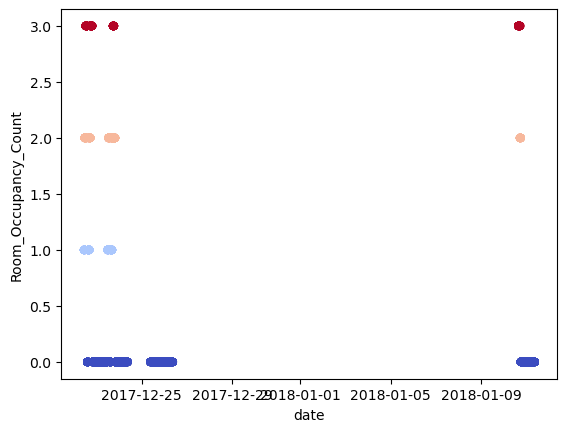

In [7]:
sns.scatterplot(data = df, x='date', y='Room_Occupancy_Count', hue = 'Room_Occupancy_Count', palette='coolwarm', edgecolor="none",legend = False)

There is large time gap between two experiments, probably because of New Year's eve

Text(0.5, 0, 'index')

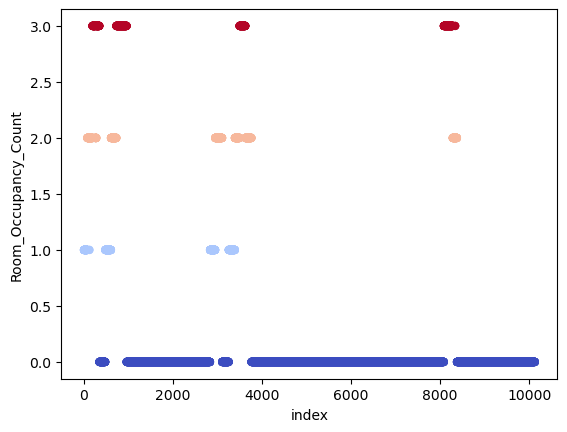

In [8]:
sns.scatterplot(data = df, x=df.index, y='Room_Occupancy_Count', hue = 'Room_Occupancy_Count', palette='coolwarm', edgecolor="none",legend = False)
plt.xlabel('index')


The default features are `temp_features`,  `light_features`, `sound_features`,`CO2_features` and `PIR_features`.

In [9]:
temp_features = ['S1_Temp','S2_Temp','S3_Temp','S4_Temp']
light_features = ['S1_Light','S2_Light','S3_Light','S4_Light']
sound_features = ['S1_Sound','S2_Sound','S3_Sound','S4_Sound']
CO2_features = ['S5_CO2','S5_CO2_Slope']
PIR_features = ['S6_PIR','S7_PIR']

### Temperature features

Adding a column `avg_temp`representing the average temperature of the four probes.

In [57]:
df['avg_temp'] = df[temp_features].mean(axis=1).rolling(10,center=True,min_periods=1).mean()

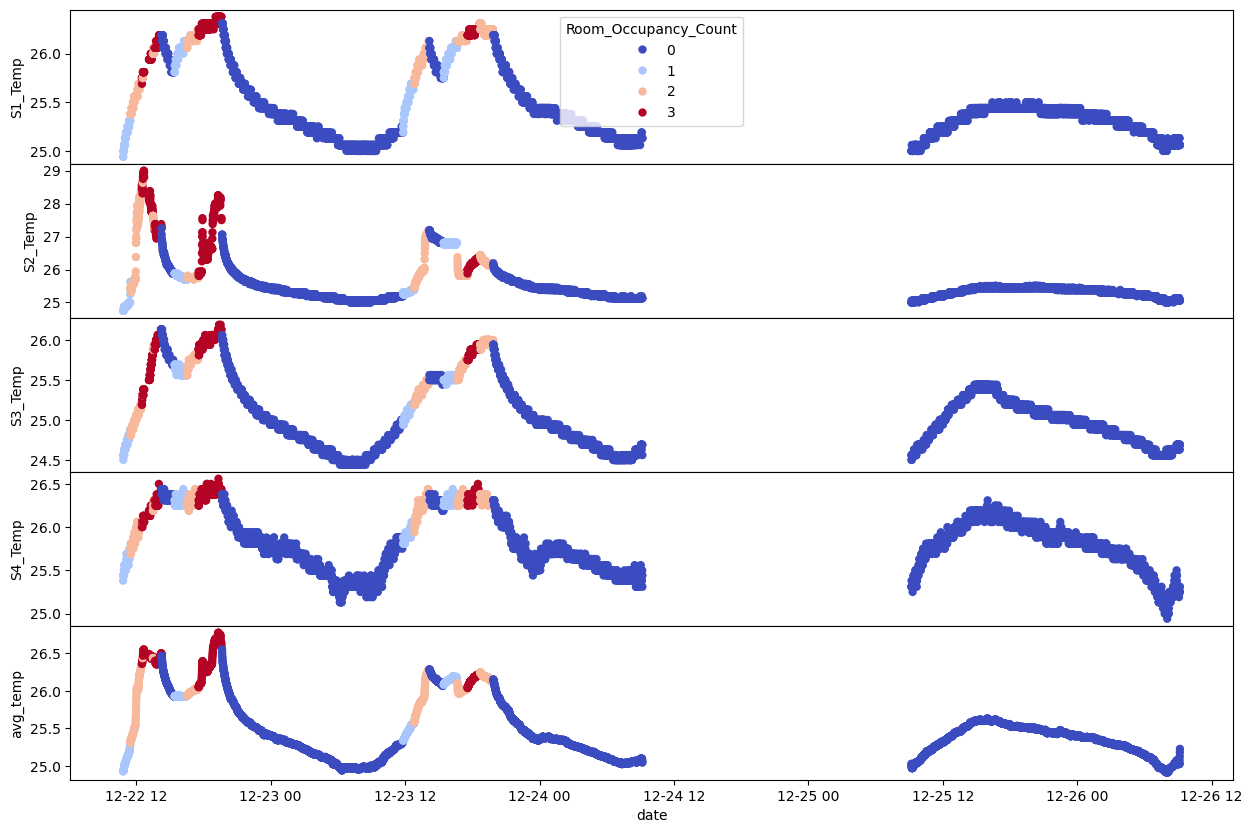

In [58]:
plot_columns_time_occupancy_2017(df,temp_features+['avg_temp'])

### Light features

Adding a column `avg_temp`representing the average temperature of the four probes.

In [66]:
df['avg_light'] = df[light_features].max(axis=1).rolling(10,center=True,min_periods=1).mean()

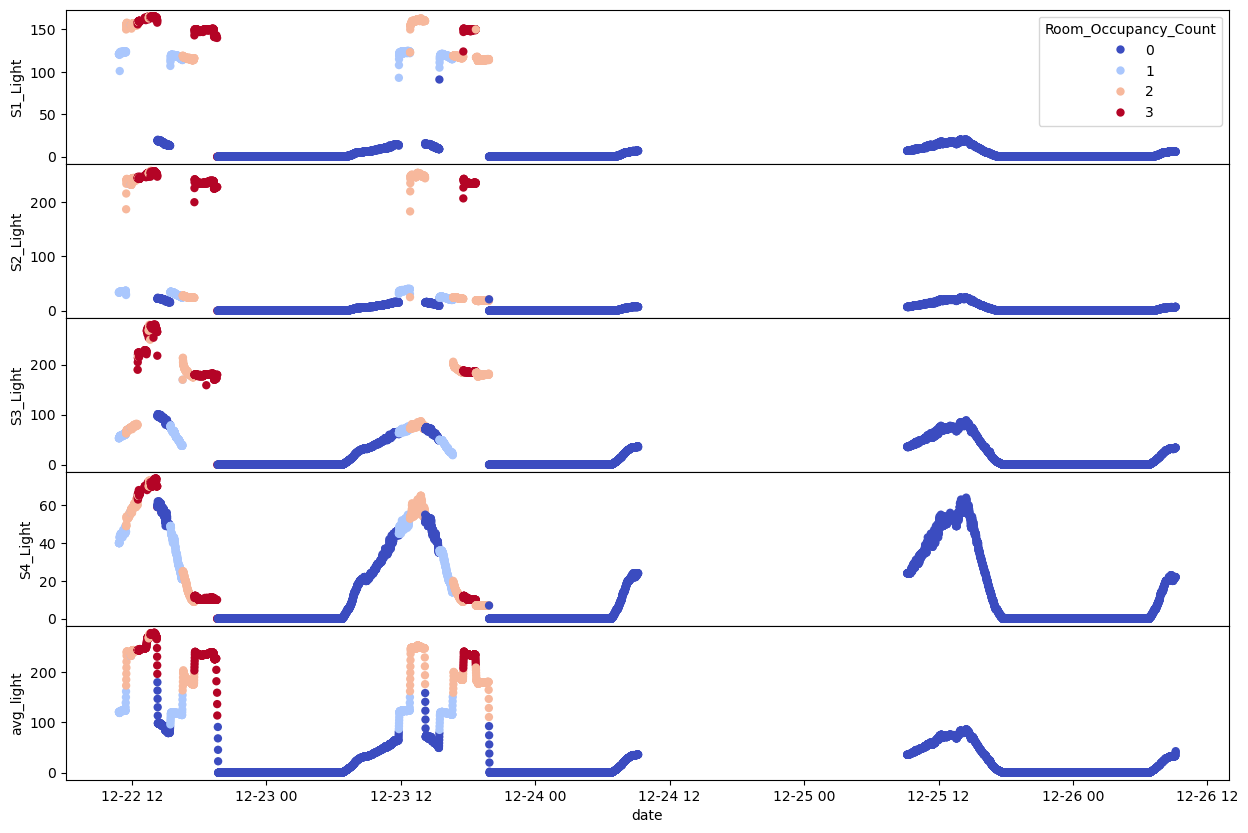

In [67]:
plot_columns_time_occupancy_2017(df,['S1_Light','S2_Light','S3_Light','S4_Light','avg_light'])

Looking at `avg_light`, we can roughly determine the occupancy by setting threshold values of 50, 100 and 150.

### Sound Features

In [61]:
df['avg_sound'] = df[['S1_Sound','S2_Sound','S3_Sound','S4_Sound']].mean(axis=1).rolling(10,center=True,min_periods=1).mean()

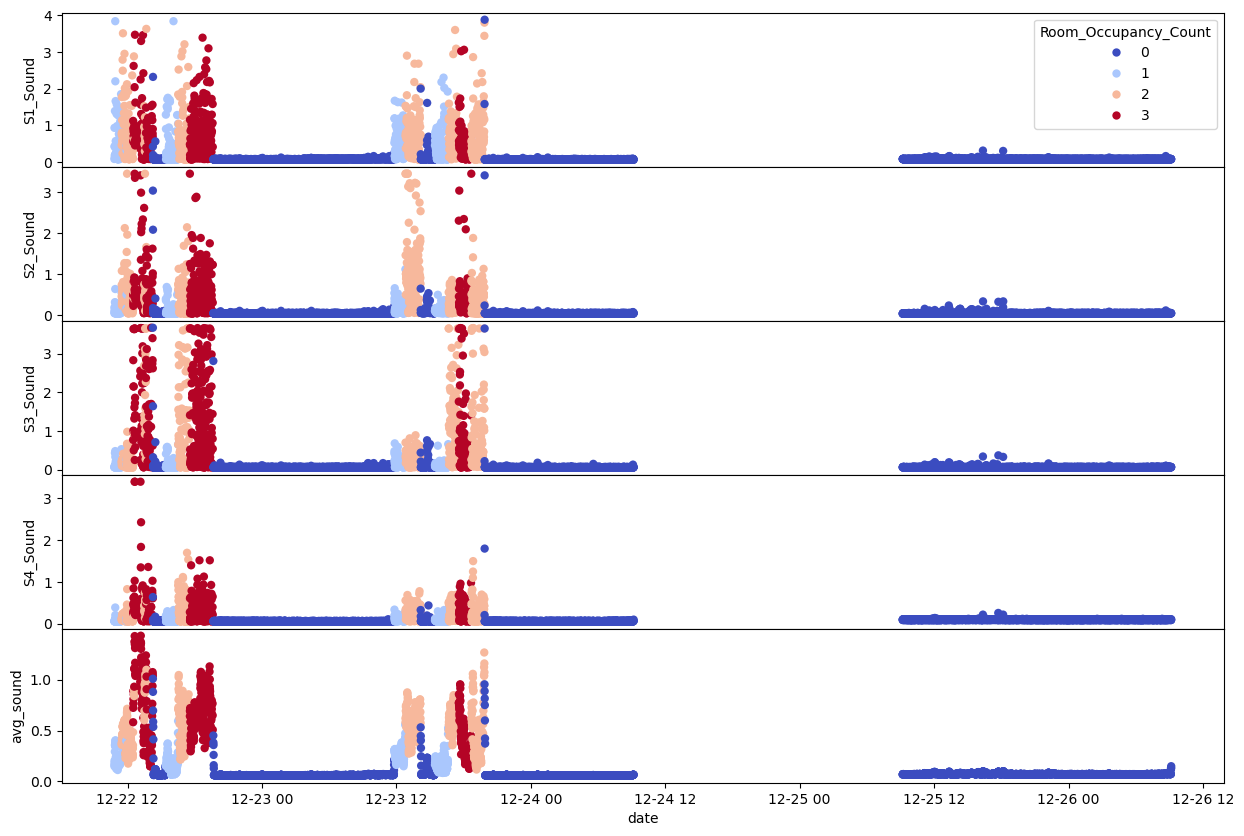

In [62]:
plot_columns_time_occupancy_2017(df,['S1_Sound','S2_Sound','S3_Sound','S4_Sound','avg_sound'])

### CO2 features

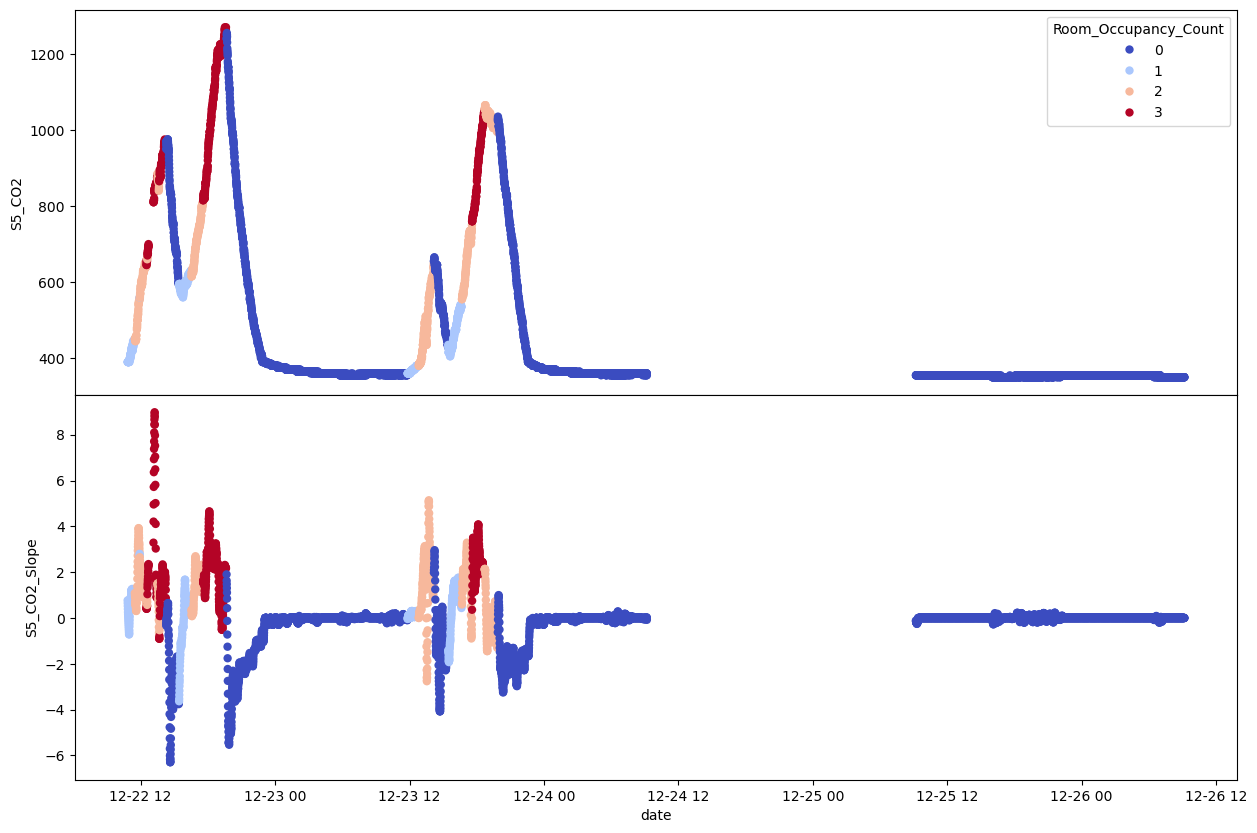

In [16]:
plot_columns_time_occupancy_2017(df,['S5_CO2','S5_CO2_Slope'])

### PIR Features

In [63]:
df['avg_PIR'] = df[['S6_PIR','S7_PIR']].mean(axis=1).rolling(10,center=True,min_periods=1).mean()
df['max_PIR'] = df[['S6_PIR','S7_PIR']].max(axis=1)
df['min_PIR'] = df[['S6_PIR','S7_PIR']].min(axis=1)

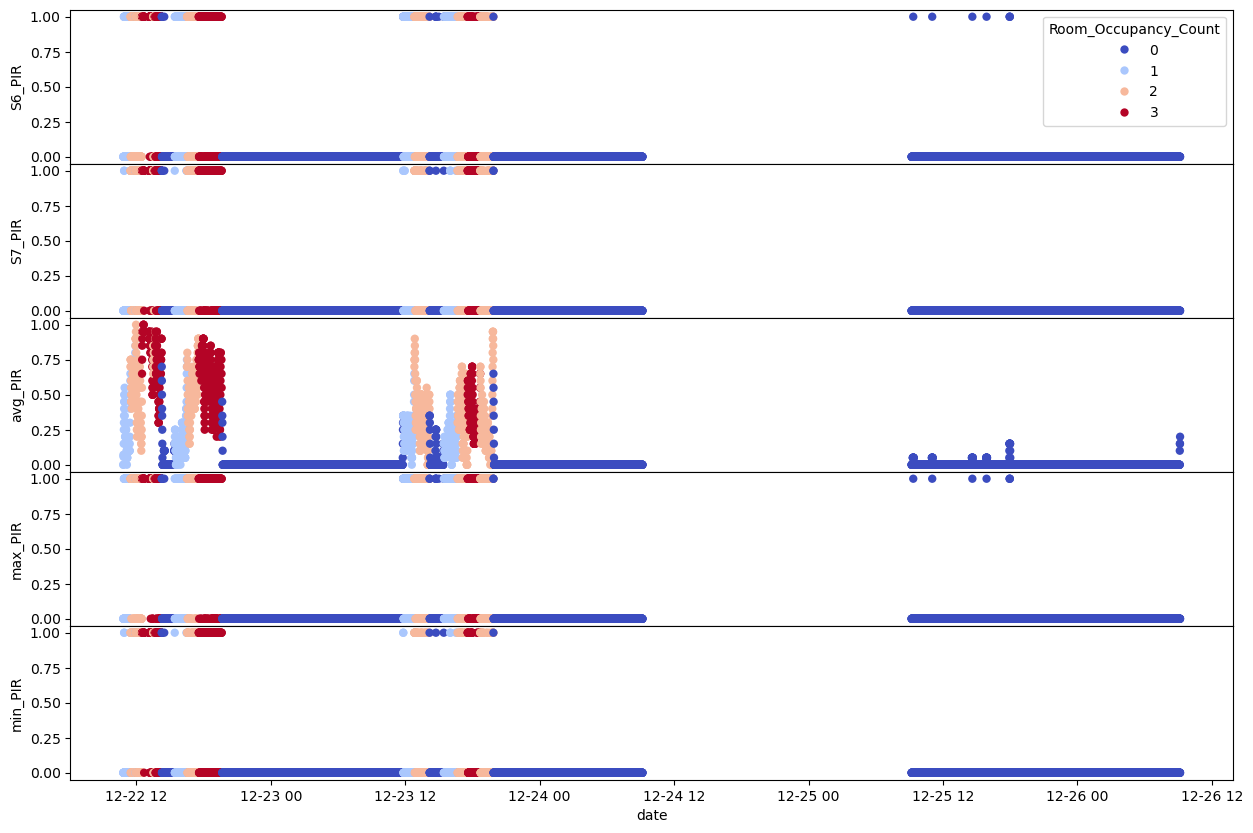

In [64]:
plot_columns_time_occupancy_2017(df,['S6_PIR','S7_PIR','avg_PIR','max_PIR','min_PIR'])

In [68]:
df.corr()['Room_Occupancy_Count'].sort_values(ascending=False)

Room_Occupancy_Count    1.000000
avg_PIR                 0.887089
avg_light               0.852129
S1_Light                0.849058
avg_sound               0.819897
S3_Light                0.793081
S2_Light                0.788764
max_PIR                 0.767223
S1_Temp                 0.700868
S7_PIR                  0.695138
avg_temp                0.691293
S2_Temp                 0.671263
S5_CO2                  0.660144
S3_Temp                 0.652047
S6_PIR                  0.633133
S5_CO2_Slope            0.601105
S1_Sound                0.573748
S2_Sound                0.557853
min_PIR                 0.550874
S3_Sound                0.531685
S4_Temp                 0.526509
S4_Sound                0.460287
S4_Light                0.355715
date                   -0.068468
Name: Room_Occupancy_Count, dtype: float64

## Preprocessing

In [69]:
df.columns

Index(['date', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count', 'avg_temp', 'avg_light', 'avg_sound', 'avg_PIR',
       'max_PIR', 'min_PIR'],
      dtype='object')

In [159]:
#X = df.copy().drop(columns=['date'])
X = df.copy().drop(columns=['date','min_PIR','max_PIR']+temp_features+light_features+sound_features+PIR_features)
y = X.pop('Room_Occupancy_Count')

In [160]:
X.head()

,S5_CO2,S5_CO2_Slope,avg_temp,avg_light,avg_sound,avg_PIR
0,390,0.769231,24.925500,121.000000,0.161500,0.000000
1,390,0.646154,24.930000,121.000000,0.147917,0.000000
2,390,0.519231,24.931071,120.857143,0.205357,0.071429
3,390,0.388462,24.933750,120.875000,0.188750,0.062500
4,390,0.253846,24.937500,121.000000,0.176944,0.055556


We first focus on a light data set containg average features.

## Model Selection

In [161]:
# model selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from xgboost import XGBClassifier


In [162]:
pca= PCA()
pca.fit(StandardScaler().fit_transform(X))

PCA()

In [165]:
pca.explained_variance_ratio_

array([0.67345104, 0.18880325, 0.05073506, 0.03527494, 0.02697549,
       0.02476023])

In [166]:
pca.components_[0]

array([0.38825262, 0.25941904, 0.41076046, 0.45509295, 0.45301689,
       0.44822273])

Set similar cross validation split as presented in paper.

In [167]:
stratified_k10fold = StratifiedKFold(n_splits=10, shuffle=False)

In [168]:
models =[    ('lr', LogisticRegression(multi_class='multinomial')),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
        ('lda', LinearDiscriminantAnalysis()),
        ('dqa', QuadraticDiscriminantAnalysis()),
        ('svc_linear', SVC(kernel='linear')),
        ('svc_rbf', SVC(kernel='rbf')),
        ('nb', GaussianNB()),
        ('rf', RandomForestClassifier()),
        ('xgb', XGBClassifier()),
]

In [169]:
for model in models:
   pipeline= Pipeline([
   ('scaler', StandardScaler()),
   (model[0], model[1])
   ])
   cross_val = cross_validate(pipeline,X,y,cv =stratified_k10fold ,scoring=['accuracy','f1_macro'],  return_train_score = True,n_jobs=-1)
   print_metrics(model,cross_val)
   print()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


('lr', LogisticRegression(multi_class='multinomial'))
metrics	 min	 mean	 max
A 	 0.916 	 0.951 	 0.978
F1 	 0.675 	 0.828 	 0.923

('knn', KNeighborsClassifier())
metrics	 min	 mean	 max
A 	 0.899 	 0.958 	 0.988
F1 	 0.796 	 0.869 	 0.954

('lda', LinearDiscriminantAnalysis())
metrics	 min	 mean	 max
A 	 0.878 	 0.933 	 0.98
F1 	 0.623 	 0.755 	 0.93

('dqa', QuadraticDiscriminantAnalysis())
metrics	 min	 mean	 max
A 	 0.859 	 0.953 	 1.0
F1 	 0.658 	 0.869 	 1.0

('svc_linear', SVC(kernel='linear'))
metrics	 min	 mean	 max
A 	 0.923 	 0.959 	 0.989
F1 	 0.772 	 0.866 	 0.961

('svc_rbf', SVC())
metrics	 min	 mean	 max
A 	 0.932 	 0.966 	 0.996
F1 	 0.745 	 0.879 	 0.985

('nb', GaussianNB())
metrics	 min	 mean	 max
A 	 0.734 	 0.939 	 1.0
F1 	 0.554 	 0.835 	 1.0

('rf', RandomForestClassifier())
metrics	 min	 mean	 max
A 	 0.929 	 0.977 	 0.995
F1 	 0.737 	 0.921 	 0.98

('xgb', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsa

Metrics such as accuracy, F1 score and confusion matrix were evalu- ated using 10-fold cross validation. Since the data is of time-series nature, data was not shuffled prior to cross validation to avoid data points similar to test data getting into the training data.

In [148]:
vc = VotingClassifier(models,voting='hard')

In [149]:
pipeline= Pipeline([
('scaler', StandardScaler()),
('vc', vc)
])
cross_val = cross_validate(pipeline,X,y,cv =stratified_k10fold ,scoring=['accuracy','f1_macro'],  return_train_score = True,n_jobs=-1)
print_metrics('vc',cross_val)
print()

/Users/clement/miniconda3/envs/DataScience/lib/python3.10/site-packages/daal4py/sklearn/linear_model/logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/clement/miniconda3/envs/DataScience/lib/python3.10/site-packages/daal4py/sklearn/linear_model/logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

vc
metrics	 min	 mean	 max
A 	 0.939 	 0.985 	 1.0
F1 	 0.753 	 0.949 	 1.0

